In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt




In [2]:
data = pd.read_csv('BITRE_Fatality-Table 1.csv')
data.head()

/var/folders/3l/xh28kn0j7_7d5hh7fgz188940000gn/T/ipykernel_3057/1511047806.py:1: DtypeWarning: Columns (10,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('BITRE_Fatality-Table 1.csv')


,Crash ID,State,Month,Year,Dayweek,Time,Crash Type,Bus Involvement,Heavy Rigid Truck Involvement,Articulated Truck Involvement,...,Age,National Remoteness Areas,SA4 Name 2021,National LGA Name 2021,National Road Type,Christmas Period,Easter Period,Age Group,Day of week,Time of day
0,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,19,NaN,NaN,NaN,NaN,No,No,17_to_25,Weekday,Night
1,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,9,NaN,NaN,NaN,NaN,No,No,0_to_16,Weekday,Night
2,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,21,NaN,NaN,NaN,NaN,No,No,17_to_25,Weekday,Night
3,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,45,NaN,NaN,NaN,NaN,No,No,40_to_64,Weekday,Night
4,20243023,Qld,4,2024,Friday,01:00,Single,No,No,No,...,24,Outer Regional Australia,Cairns,Cairns,Local Road,No,No,17_to_25,Weekday,Night


19:45:01 - cmdstanpy - INFO - Chain [1] start processing
19:45:01 - cmdstanpy - INFO - Chain [1] done processing
19:45:01 - cmdstanpy - INFO - Chain [1] start processing
19:45:01 - cmdstanpy - INFO - Chain [1] done processing


Evaluation Metrics for the Test Period (2023) - Day of week:
Weekday - MAE: 9.82, MSE: 125.92, MAPE: 14.78%, R2: -0.60
Forecast vs Actual for first three months of 2024 for Weekday:
            ds       yhat  yhat_lower  yhat_upper
420 2024-01-01  63.259051   41.127548   85.486512
421 2024-02-01  49.954366   29.800302   72.125146
422 2024-03-01  61.523427   39.511374   83.881994
        Date  Counts
0 2024-01-01      71
1 2024-02-01      65
2 2024-03-01      68

Weekend - MAE: 5.18, MSE: 38.24, MAPE: 12.38%, R2: 0.49
Forecast vs Actual for first three months of 2024 for Weekend:
            ds       yhat  yhat_lower  yhat_upper
420 2024-01-01  24.681620    8.591053   41.926668
421 2024-02-01  33.817408   16.745057   49.763633
422 2024-03-01  44.672116   27.027750   61.543681
        Date  Counts
0 2024-01-01      27
1 2024-02-01      48
2 2024-03-01      45



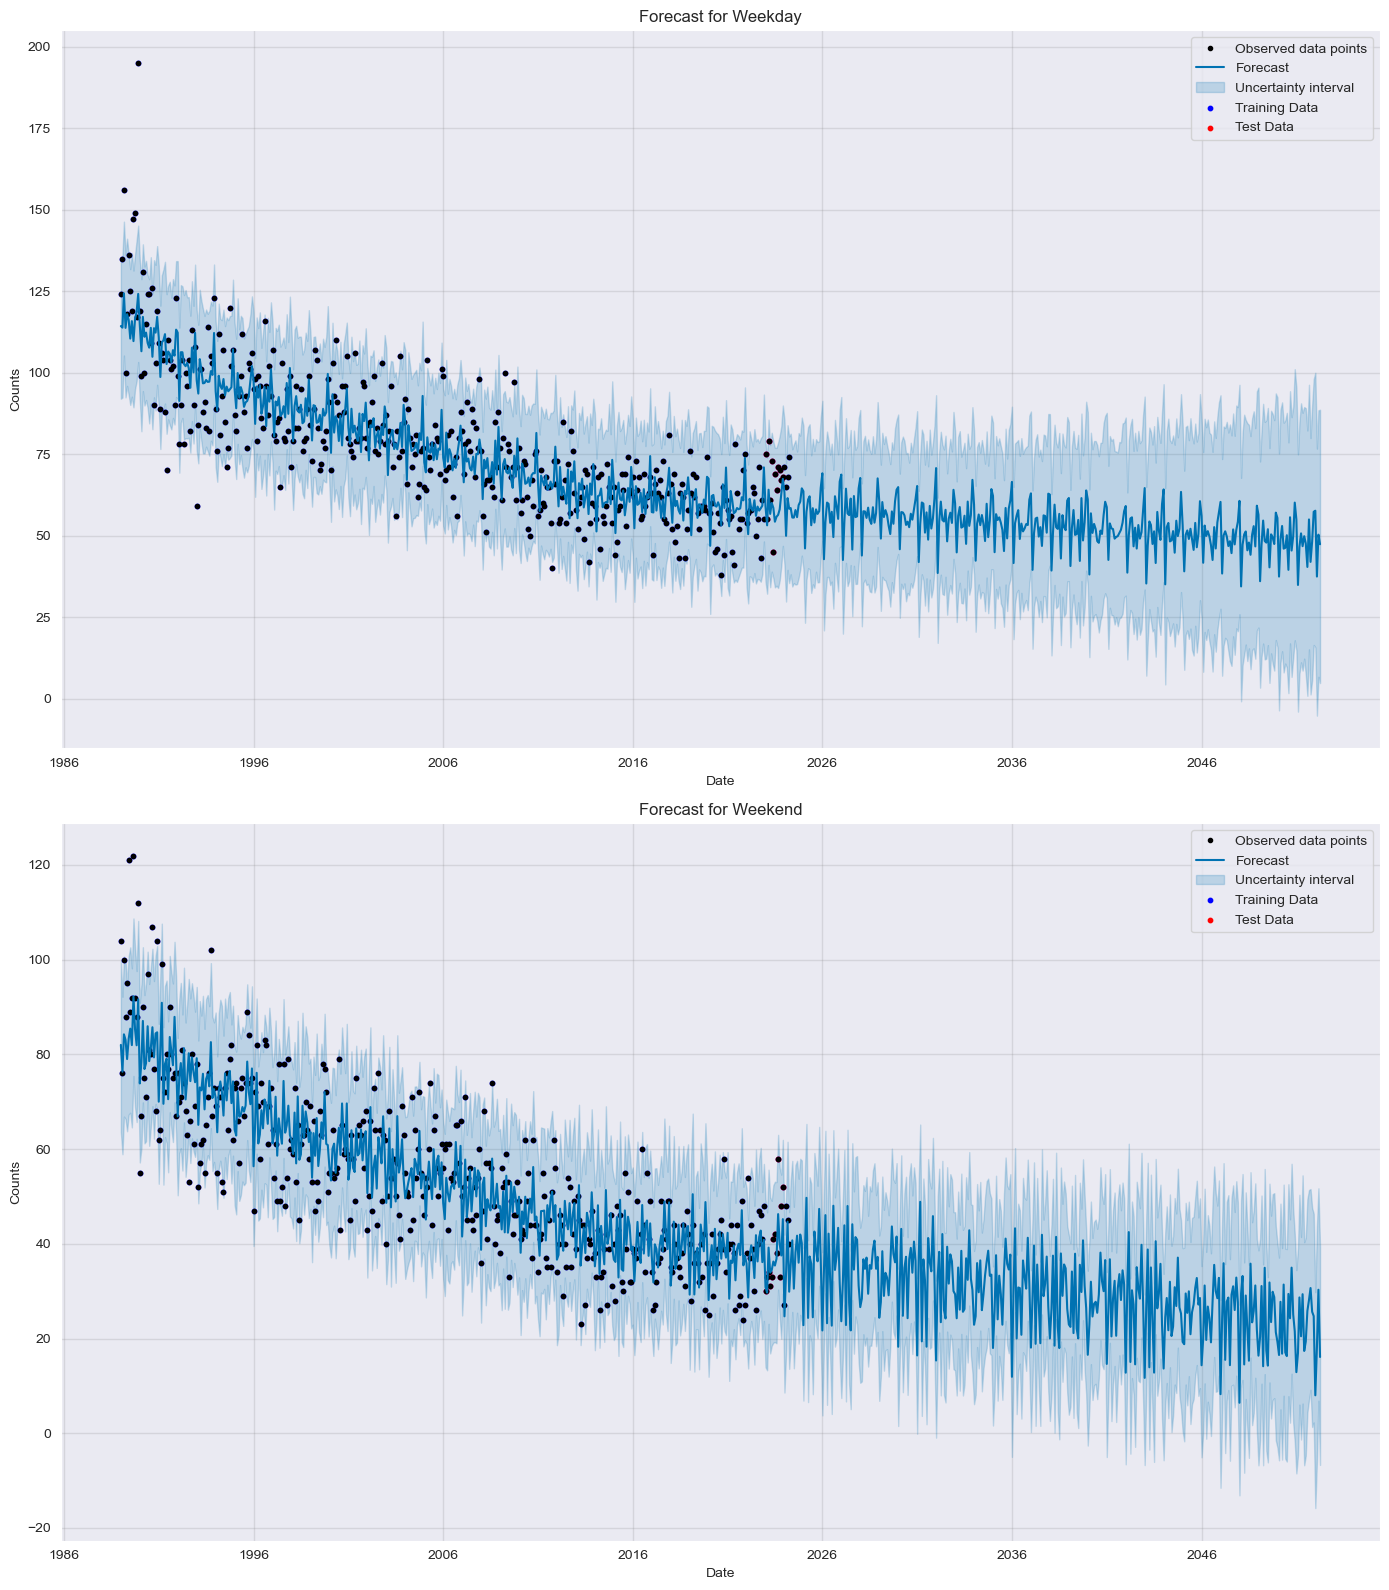

Dickey-Fuller Test Results:

Time of day: Weekday
ADF Statistic: -4.494892529128244
p-value: 0.00020086097903953819
Critical Value 1%: -3.4463221132914486
Critical Value 5%: -2.8685808072418824
Critical Value 10%: -2.570520529031954

Time of day: Weekend
ADF Statistic: -2.8686170698252766
p-value: 0.049121009261678256
Critical Value 1%: -3.4464005219454155
Critical Value 5%: -2.868615280538588
Critical Value 10%: -2.570538905413444


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    return (abs((y_true - y_pred) / y_true)).mean() * 100

# Convert the 'Year' and 'Month' columns to a single datetime column
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

# Filter data up to 2022 for training and 2023 for testing
train_data = data[data['Year'] <= 2022]
test_data = data[data['Year'] == 2023]

# Aggregate the number of occurrences of each feature per month for training data
def aggregate_counts(data, feature):
    return data.groupby(['Date', feature]).size().reset_index(name='Counts')

# Prepare the data for Prophet and forecast
def forecast_feature(data, feature):
    counts = aggregate_counts(data, feature)
    
    models = {}
    forecasts = {}
    for value in counts[feature].unique():
        value_data = counts[counts[feature] == value]
        value_data = value_data[['Date', 'Counts']].rename(columns={'Date': 'ds', 'Counts': 'y'})

        # Initialize and fit the Prophet model
        model = Prophet(interval_width=0.95,
                        yearly_seasonality=True,
                        daily_seasonality=True,
                        weekly_seasonality=True,
                        seasonality_mode='additive')
        model.fit(value_data)
        models[value] = model

        # Create a dataframe for future dates including 2023 (test period) and beyond
        future_dates = model.make_future_dataframe(periods=(2050 - 2022) * 12, freq='M')

        # Predict future values
        forecast = model.predict(future_dates)
        forecasts[value] = forecast
    
    return models, forecasts

# Forecast for a specific feature
feature = 'Day of week'  # Change this to the desired feature
time_of_day_models, forecasts = forecast_feature(data, feature)

# Calculate and print evaluation metrics for the test period (2023)
print(f"Evaluation Metrics for the Test Period (2023) - {feature}:")
for value, forecast in forecasts.items():
    # Filter forecast for 2023
    forecast_2023 = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2023-12-31')]

    # Filter actual counts for 2023
    actual_counts_2023 = test_data[test_data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    actual_counts_2023 = actual_counts_2023.rename(columns={'Date': 'ds', 'Counts': 'y'})

    # Ensure the forecast and actual data are aligned
    forecast_2023 = forecast_2023.set_index('ds').loc[actual_counts_2023['ds']].reset_index()

    # Calculate evaluation metrics
    mae = mean_absolute_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mse = mean_squared_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mape = mean_absolute_percentage_error(actual_counts_2023['y'], forecast_2023['yhat'])
    r2 = r2_score(actual_counts_2023['y'], forecast_2023['yhat'])

    print(f"{value} - MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}%, R2: {r2:.2f}")
    print(f"Forecast vs Actual for first three months of 2024 for {value}:")
    future_2024 = forecast[(forecast['ds'] >= '2024-01-01') & (forecast['ds'] <= '2024-03-31')]
    print(future_2024[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

    # Filter actual counts for first three months of 2024
    actual_counts_2024 = data[(data['Date'] >= '2024-01-01') & (data['Date'] <= '2024-03-31') & (data[feature] == value)]
    actual_counts_2024 = actual_counts_2024.groupby('Date').size().reset_index(name='Counts')
    print(actual_counts_2024)
    print()

# Plot the forecasts
fig, axes = plt.subplots(nrows=len(forecasts), ncols=1, figsize=(14, 8*len(forecasts)))

for ax, (value, forecast) in zip(axes, forecasts.items()):
    model = time_of_day_models[value]
    model.plot(forecast, ax=ax, xlabel='Date', ylabel='Counts')
    
    # Plot training data
    train_time_data = data[data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    ax.scatter(train_time_data['Date'], train_time_data['Counts'], color='blue', s=10, label='Training Data')
    
    # Plot test data
    test_time_data = test_data[test_data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    ax.scatter(test_time_data['Date'], test_time_data['Counts'], color='red', s=10, label='Test Data')
    
    ax.legend()
    ax.set_title(f'Forecast for {value}')

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot
fig.savefig(f'{feature}_forecast.png')

# Perform Dickey-Fuller Test
print("Dickey-Fuller Test Results:")
for value, forecast in forecasts.items():
    time_data = data[data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    adf_result = adfuller(time_data['Counts'])
    print(f"\nTime of day: {value}")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    for key, value in adf_result[4].items():
        print(f"Critical Value {key}: {value}")


Optimized Code

00:02:19 - cmdstanpy - INFO - Chain [1] start processing
00:02:19 - cmdstanpy - INFO - Chain [1] done processing
00:02:19 - cmdstanpy - INFO - Chain [1] start processing
00:02:19 - cmdstanpy - INFO - Chain [1] done processing


Evaluation Metrics for the Test Period (2023) - Day of week:
Weekday - MAE: 9.82, MSE: 125.92, MAPE: 14.78%, R2: -0.60
Forecast vs Actual for first three months of 2024 for Weekday:
            ds       yhat  yhat_lower  yhat_upper
420 2024-01-01  63.259051   41.670573   86.373077
421 2024-02-01  49.954366   28.824146   71.935196
422 2024-03-01  61.523427   38.163322   83.290956
        Date  Counts
0 2024-01-01      71
1 2024-02-01      65
2 2024-03-01      68

Forecast for Weekday in 2030:
            ds       yhat  yhat_lower  yhat_upper
493 2030-01-31  45.832267   22.141987   67.691998
494 2030-02-28  57.242955   36.604382   79.014405
495 2030-03-31  57.127242   34.363013   79.158752
496 2030-04-30  56.260282   34.933506   78.153961
497 2030-05-31  53.295951   31.835395   73.268161
498 2030-06-30  54.294677   32.437271   77.565958
499 2030-07-31  52.597280   30.865806   74.139163
500 2030-08-31  56.735754   33.503624   79.313482
501 2030-09-30  54.915237   32.945540   74.979126
502

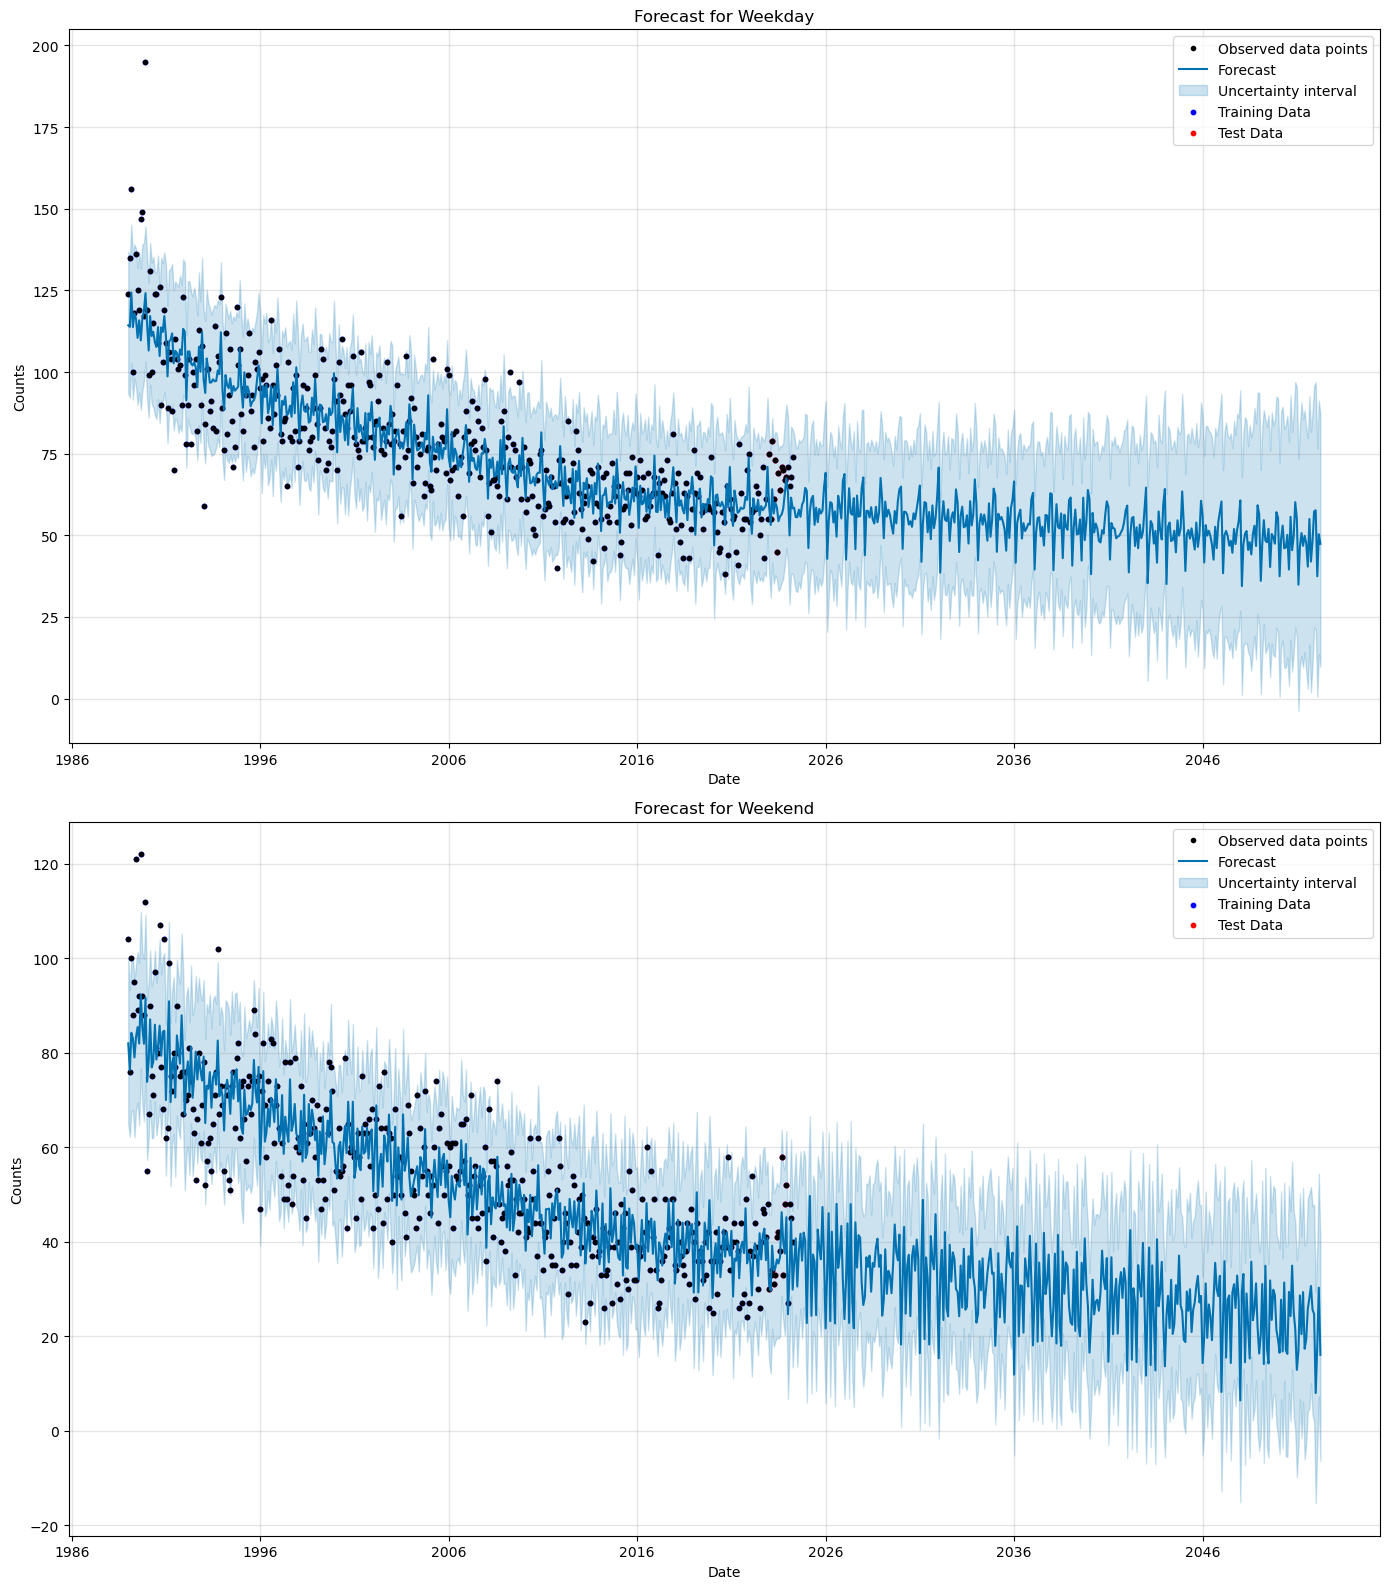

Dickey-Fuller Test Results:

Time of day: Weekday
ADF Statistic: -4.494892529128244
p-value: 0.00020086097903953819
Critical Value 1%: -3.4463221132914486
Critical Value 5%: -2.8685808072418824
Critical Value 10%: -2.570520529031954

Time of day: Weekend
ADF Statistic: -2.8686170698252766
p-value: 0.049121009261678256
Critical Value 1%: -3.4464005219454155
Critical Value 5%: -2.868615280538588
Critical Value 10%: -2.570538905413444

Actual Counts per Year (2013-2023):
Year 2013: 1186 counts
Year 2014: 1150 counts
Year 2015: 1206 counts
Year 2016: 1294 counts
Year 2017: 1223 counts
Year 2018: 1135 counts
Year 2019: 1186 counts
Year 2020: 1097 counts
Year 2021: 1130 counts
Year 2022: 1180 counts
Year 2023: 1270 counts


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    return (abs((y_true - y_pred) / y_true)).mean() * 100

# Convert the 'Year' and 'Month' columns to a single datetime column
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

# Filter data up to 2022 for training and 2023 for testing
train_data = data[data['Year'] <= 2022]
test_data = data[data['Year'] == 2023]

# Aggregate the number of occurrences of each feature per month for training data
def aggregate_counts(data, feature):
    return data.groupby(['Date', feature]).size().reset_index(name='Counts')

# Prepare the data for Prophet and forecast
def forecast_feature(data, feature):
    counts = aggregate_counts(data, feature)
    
    models = {}
    forecasts = {}
    for value in counts[feature].unique():
        value_data = counts[counts[feature] == value]
        value_data = value_data[['Date', 'Counts']].rename(columns={'Date': 'ds', 'Counts': 'y'})

        # Initialize and fit the Prophet model
        model = Prophet(interval_width=0.95,
                        yearly_seasonality=True,
                        daily_seasonality=True,
                        weekly_seasonality=True,
                        seasonality_mode='additive')
        model.fit(value_data)
        models[value] = model

        # Create a dataframe for future dates including 2023 (test period) and beyond
        future_dates = model.make_future_dataframe(periods=(2050 - 2022) * 12, freq='M')

        # Predict future values
        forecast = model.predict(future_dates)
        forecasts[value] = forecast
    
    return models, forecasts

# Forecast for a specific feature
feature = 'Day of week'  # Change this to the desired feature
time_of_day_models, forecasts = forecast_feature(data, feature)

# Calculate and print evaluation metrics for the test period (2023)
print(f"Evaluation Metrics for the Test Period (2023) - {feature}:")
for value, forecast in forecasts.items():
    # Filter forecast for 2023
    forecast_2023 = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2023-12-31')]

    # Filter actual counts for 2023
    actual_counts_2023 = test_data[test_data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    actual_counts_2023 = actual_counts_2023.rename(columns={'Date': 'ds', 'Counts': 'y'})

    # Ensure the forecast and actual data are aligned
    forecast_2023 = forecast_2023.set_index('ds').loc[actual_counts_2023['ds']].reset_index()

    # Calculate evaluation metrics
    mae = mean_absolute_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mse = mean_squared_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mape = mean_absolute_percentage_error(actual_counts_2023['y'], forecast_2023['yhat'])
    r2 = r2_score(actual_counts_2023['y'], forecast_2023['yhat'])

    print(f"{value} - MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}%, R2: {r2:.2f}")
    print(f"Forecast vs Actual for first three months of 2024 for {value}:")
    future_2024 = forecast[(forecast['ds'] >= '2024-01-01') & (forecast['ds'] <= '2024-03-31')]
    print(future_2024[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

    # Filter actual counts for first three months of 2024
    actual_counts_2024 = data[(data['Date'] >= '2024-01-01') & (data['Date'] <= '2024-03-31') & (data[feature] == value)]
    actual_counts_2024 = actual_counts_2024.groupby('Date').size().reset_index(name='Counts')
    print(actual_counts_2024)
    print()

    # Print forecast for 2030, 2040, and 2050
    future_2030 = forecast[(forecast['ds'] >= '2030-01-01') & (forecast['ds'] <= '2030-12-31')]
    future_2040 = forecast[(forecast['ds'] >= '2040-01-01') & (forecast['ds'] <= '2040-12-31')]
    future_2050 = forecast[(forecast['ds'] >= '2050-01-01') & (forecast['ds'] <= '2050-12-31')]
    
    print(f"Forecast for {value} in 2030:")
    print(future_2030[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
    print()
    
    print(f"Forecast for {value} in 2040:")
    print(future_2040[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
    print()
    
    print(f"Forecast for {value} in 2050:")
    print(future_2050[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
    print()

# Plot the forecasts
fig, axes = plt.subplots(nrows=len(forecasts), ncols=1, figsize=(14, 8*len(forecasts)))

for ax, (value, forecast) in zip(axes, forecasts.items()):
    model = time_of_day_models[value]
    model.plot(forecast, ax=ax, xlabel='Date', ylabel='Counts')
    
    # Plot training data
    train_time_data = data[data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    ax.scatter(train_time_data['Date'], train_time_data['Counts'], color='blue', s=10, label='Training Data')
    
    # Plot test data
    test_time_data = test_data[test_data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    ax.scatter(test_time_data['Date'], test_time_data['Counts'], color='red', s=10, label='Test Data')
    
    ax.legend()
    ax.set_title(f'Forecast for {value}')

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot

# Perform Dickey-Fuller Test
print("Dickey-Fuller Test Results:")
for value, forecast in forecasts.items():
    time_data = data[data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    adf_result = adfuller(time_data['Counts'])
    print(f"\nTime of day: {value}")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    for key, value in adf_result[4].items():
        print(f"Critical Value {key}: {value}")

# Print actual counts for each year from 2013 to 2023
print("\nActual Counts per Year (2013-2023):")
for year in range(2013, 2024):
    year_counts = data[data['Year'] == year].groupby('Year').size().reset_index(name='Counts')
    print(f"Year {year}: {year_counts['Counts'].sum()} counts")
